<h1 style="text-align: center;">Stuff+ Model</h1>

## Loading Libraries

In [1]:
## pyb stuff
import pybaseball as pyb
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import schedule_and_record

import pandas as pd 
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## added yesterday's date so the data we get is updated everytime the statcast data cell is ran
from datetime import date, timedelta, datetime
today = date.today()
yesterday = today - timedelta(days=1)
formatted_date = yesterday.strftime("%Y-%m-%d")

## ML stuff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import root_mean_squared_error
scaler = StandardScaler()

## linear model
from pygam import LinearGAM, s, f


import warnings
warnings.filterwarnings("ignore")

## Helper Functions

In [2]:
def clean_metric(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    imputes the missing data within the columns with the average of each pitcher's pitch

    Arguments: df: the df that has the uncleaned cols, l: the metric to be cleaned
    """
    df = df.copy()
    df[col] = df[col].fillna(df.groupby(['pitcher', 'pitch_type'])[col].transform('mean'))
    return df

In [3]:
def catch_made_hist(df: pd.DataFrame, column: str, ax=None) -> None:
    """
    Displays overlapping histograms between successful catches and not for some column
    
    Arguments: column: is some quantitative column in df
    """
    df = df.copy()

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
        
    ax.hist(df[df['is_csw'] == 0][column], bins=25, alpha=0.7, label='CSW == 0', color='#CC3433', density=True)
    ax.hist(df[df['is_csw'] == 1][column], bins=25, alpha=0.7, label='CSW == 1', color='#89CFF0', density=True)
    ax.set_xlabel(column.replace('_', ' '))
    ax.set_ylabel('Density')
    ax.set_title(f"{column.replace('_', ' ')} Histograms\n Comparisons")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

## Loading in the Data

In [44]:
## the code below to run the data takes like 5 1/2 min to run but we get 4 years worth of data
start_date = '2023-03-01'
end_date = formatted_date

## gets rid of 08/18/24 --> it's coming as an error on my end for some reason
statcast_data_p1 = pyb.statcast(start_date, '2024-08-17')
statcast_data_p2 = pyb.statcast('2024-08-19', '2025-07-15')

statcast_data = pd.concat([statcast_data_p1, statcast_data_p2]).sort_values(by='game_date').reset_index(drop=True)
statcast_data = statcast_data[~statcast_data['pitch_type'].isna()].sort_values(by='game_date').reset_index(drop=True) ## gets rid of the null pitches
statcast_data.head()

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


 44%|████▍     | 178/402 [01:52<02:21,  1.58it/s]


ParserError: Error tokenizing data. C error: Expected 1 fields in line 13, saw 2


In [15]:
## preparing the data
important_stuff_cols = ['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'pitcher',
                        'events', 'description', 'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'on_3b', 'on_2b', 'on_1b',
                        'outs_when_up', 'release_spin_rate', 'release_extension', 'pitch_name', 'spin_axis',
                        'delta_pitcher_run_exp', 'stand', 'zone']

statcast_data_cleaned = statcast_data[important_stuff_cols].copy()
statcast_data_cleaned['on_1b'] = statcast_data_cleaned['on_1b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned['on_2b'] = statcast_data_cleaned['on_2b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned['on_3b'] = statcast_data_cleaned['on_3b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned[['pfx_x', 'pfx_z']] = statcast_data_cleaned[['pfx_x', 'pfx_z']] * 12
misc_pitches = ['Eephus', 'Pitch Out', 'Slow Curve', 'Knuckleball', 'Forkball', 'Screwball', 'Slurve', 'Knuckle Curve', 'Other']
statcast_data_cleaned = statcast_data_cleaned[~statcast_data_cleaned['pitch_name'].isin(misc_pitches)].reset_index(drop=True).copy()

## cleans the delta_pitcher_run_exp by giving it the proper run expectancy change
statcast_data_cleaned.loc[616354, 'delta_pitcher_run_exp'] = -0.115
statcast_data_cleaned.loc[616355, 'delta_pitcher_run_exp'] = 0.298

## makes sure spin rate is a float
statcast_data_cleaned['release_spin_rate'] = pd.to_numeric(statcast_data_cleaned['release_spin_rate'], errors='coerce').astype(float)
## makes sure spin axis is a float
statcast_data_cleaned['spin_axis'] = pd.to_numeric(statcast_data_cleaned['spin_axis'], errors='coerce').astype(float)

## encoding the binary variables
statcast_data_cleaned['p_throws'] = statcast_data_cleaned['p_throws'].apply(lambda x: x=='R').astype(int)
statcast_data_cleaned['stand'] = statcast_data_cleaned['stand'].apply(lambda x: x=='R').astype(int)

statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_speed')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_pos_x')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_pos_z')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'pfx_x')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'pfx_z')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_spin_rate')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_extension')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'spin_axis')

## gets rid of the plays that had missing values for each pitch metric
statcast_data_cleaned = statcast_data_cleaned[~statcast_data_cleaned['release_spin_rate'].isna()].reset_index(drop=True).copy()

statcast_data_cleaned['is_csw'] = statcast_data_cleaned['description'].apply(lambda x: x in ['called_strike', 'swinging_strike', 'swinging_strike_blocked']).astype(int)
statcast_data_cleaned = statcast_data_cleaned.rename(columns={'pfx_x': 'horz_break', 
                                                              'pfx_z': 'induced_vert_break',
                                                              'release_pos_x': 'rel_side',
                                                              'release_pos_z': 'rel_height',
                                                              'release_spin_rate': 'spin_rate',
                                                              'release_extension': 'extension'
                                                              }).copy()

In [17]:
## mirror handedness metrics
statcast_data_cleaned['rel_side'] *= -1
statcast_data_cleaned['horz_break'] *= -1
statcast_data_cleaned = statcast_data_cleaned.drop(columns = ['p_throws']).copy()

statcast_data_cleaned.head()

,pitch_type,release_speed,rel_side,rel_height,player_name,pitcher,events,description,balls,strikes,horz_break,induced_vert_break,on_3b,on_2b,on_1b,outs_when_up,spin_rate,extension,pitch_name,spin_axis,delta_pitcher_run_exp,stand,zone,is_csw
0,FF,98.1,-1.89,5.51,"Pearson, Nate",663878,NaN,foul,2,0,-9.12,13.2,0,0,1,2,2143.0,6.9,4-Seam Fastball,213.0,0.048,1,13,0
1,CU,77.2,-1.99,6.07,"Smith-Shawver, AJ",700363,field_out,hit_into_play,2,2,8.16,-12.84,1,0,1,0,2257.0,6.8,Curveball,21.0,0.201,1,14,0
2,FF,96.4,-2.36,6.0,"Smith-Shawver, AJ",700363,triple,hit_into_play,1,1,-9.36,14.4,0,0,0,0,2161.0,6.9,4-Seam Fastball,209.0,-0.997,0,9,0
3,SL,87.3,-2.38,6.02,"Smith-Shawver, AJ",700363,NaN,blocked_ball,0,0,6.48,4.2,1,0,0,0,2083.0,6.9,Slider,209.0,-0.066,1,14,0
4,SL,86.5,-2.46,6.08,"Smith-Shawver, AJ",700363,NaN,swinging_strike,1,0,2.52,6.48,1,0,0,0,2120.0,6.7,Slider,220.0,0.093,1,5,1


### EDA

In [23]:
X = statcast_data_cleaned[['delta_pitcher_run_exp', 'release_speed', 'spin_rate', 'horz_break', 'induced_vert_break', 'spin_axis', 'extension', 'rel_side', 'rel_height', 'pitch_type']].copy()
cols_to_standardize = ['release_speed', 'spin_rate', 'horz_break', 'induced_vert_break', 'spin_axis', 'extension', 'rel_side', 'rel_height']
X[cols_to_standardize] = (X.groupby('pitch_type')[cols_to_standardize].transform(lambda x: (x - x.mean()) / x.std()))
X

,delta_pitcher_run_exp,release_speed,spin_rate,horz_break,induced_vert_break,spin_axis,extension,rel_side,rel_height,pitch_type
0,0.048,1.550699,-0.919143,-0.731371,-0.860259,0.544326,0.858752,-0.601977,-0.652859,FF
1,0.201,-0.637055,-0.988882,0.381182,-0.634623,-0.819832,0.85349,-0.739734,0.286438,CU
2,-0.997,0.856488,-0.811441,-0.761145,-0.453873,0.426534,0.858752,-0.857412,0.379355,FF
3,-0.066,0.523566,-1.412052,0.693993,0.618102,0.766777,1.024386,-0.746425,0.459368,SL
4,0.093,0.257815,-1.262210,-0.001629,1.168241,0.896590,0.584557,-0.789321,0.5697,SL
...,...,...,...,...,...,...,...,...,...,...
719872,-0.083,0.413258,-0.214692,0.878788,-0.92187,-0.708678,-1.693947,-1.153514,1.401602,ST
719873,-0.108,1.183176,0.732296,-0.25499,0.277621,0.338190,0.173038,-0.303065,-0.547531,FF
719874,0.051,1.128776,0.618708,1.257985,0.18317,-0.072401,0.231338,-0.135512,-0.739279,FC
719875,-0.059,0.774816,0.648528,-0.150781,0.805922,0.279294,-0.055533,-0.28676,-0.421138,FF


In [26]:
import statsmodels.formula.api as smf

#cleaning
X = X.replace({pd.NA: np.nan})
X = X.astype({col: float for col in ["release_speed", "spin_rate", 
                                     "horz_break", "induced_vert_break", 
                                     "spin_axis", "extension", 
                                     "rel_side", "rel_height"]})
X = X.dropna(subset=["delta_pitcher_run_exp", "release_speed", "spin_rate",
                     "horz_break", "induced_vert_break", "spin_axis", 
                     "extension", "rel_side", "rel_height"])

model = smf.mixedlm("delta_pitcher_run_exp ~ release_speed + spin_rate + horz_break + induced_vert_break + spin_axis + extension + rel_side + rel_height", 
                    data=X, groups=X["pitch_type"]).fit()
print(model.summary())

y_pred = model.predict(X)
y_pred

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: delta_pitcher_run_exp
No. Observations: 719875  Method:             REML                 
No. Groups:       8       Scale:              0.0501               
Min. group size:  22705   Log-Likelihood:     56346.0265           
Max. group size:  236091  Converged:          Yes                  
Mean group size:  89984.4                                          
--------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept            -0.000     0.079  -0.002  0.999  -0.155   0.155
release_speed         0.002     0.000   7.208  0.000   0.001   0.003
spin_rate             0.002     0.000   7.005  0.000   0.001   0.002
horz_break            0.001     0.000   1.431  0.152  -0.000   0.002
induced_vert_break    0.000     0.000   0.716  0.474  -0

0         0.001995
1        -0.003954
2        -0.000218
3        -0.000270
4        -0.001337
            ...   
719872   -0.003706
719873    0.004242
719874    0.004865
719875    0.003052
719876   -0.000783
Length: 719875, dtype: float64

In [27]:
X['run_value'] = y_pred
X['stuff'] = X.groupby('pitch_type')['run_value'].transform(lambda x: ((x - x.mean()) / x.std()))

In [28]:
X['stuff+'] = X['stuff'].apply(lambda x: 100 + (10*x))
X

,delta_pitcher_run_exp,release_speed,spin_rate,horz_break,induced_vert_break,spin_axis,extension,rel_side,rel_height,pitch_type,run_value,stuff,stuff+
0,0.048,1.550699,-0.919143,-0.731371,-0.860259,0.544326,0.858752,-0.601977,-0.652859,FF,0.001995,0.624576,106.245763
1,0.201,-0.637055,-0.988882,0.381182,-0.634623,-0.819832,0.853490,-0.739734,0.286438,CU,-0.003954,-1.165506,88.344943
2,-0.997,0.856488,-0.811441,-0.761145,-0.453873,0.426534,0.858752,-0.857412,0.379355,FF,-0.000218,-0.026455,99.735451
3,-0.066,0.523566,-1.412052,0.693993,0.618102,0.766777,1.024386,-0.746425,0.459368,SL,-0.000270,-0.047454,99.525461
4,0.093,0.257815,-1.262210,-0.001629,1.168241,0.896590,0.584557,-0.789321,0.569700,SL,-0.001337,-0.403601,95.963987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
719872,-0.083,0.413258,-0.214692,0.878788,-0.921870,-0.708678,-1.693947,-1.153514,1.401602,ST,-0.003706,-1.172754,88.272459
719873,-0.108,1.183176,0.732296,-0.254990,0.277621,0.338190,0.173038,-0.303065,-0.547531,FF,0.004242,1.285555,112.855549
719874,0.051,1.128776,0.618708,1.257985,0.183170,-0.072401,0.231338,-0.135512,-0.739279,FC,0.004865,1.443241,114.432413
719875,-0.059,0.774816,0.648528,-0.150781,0.805922,0.279294,-0.055533,-0.286760,-0.421138,FF,0.003052,0.935591,109.355910


In [29]:
X['pitcher'] = statcast_data_cleaned['player_name']

In [30]:
X.groupby(['pitcher', 'pitch_type'])['stuff+'].mean()

pitcher         pitch_type
Abbott, Andrew  CH            109.232441
                CU            112.465875
                FF             97.870965
                SL            110.766162
                ST            111.750089
                                 ...    
de Geus, Brett  SI            100.608345
deGrom, Jacob   CH            111.081581
                CU            108.403295
                FF            117.344629
                SL            118.278196
Name: stuff+, Length: 4166, dtype: float64

<Axes: >

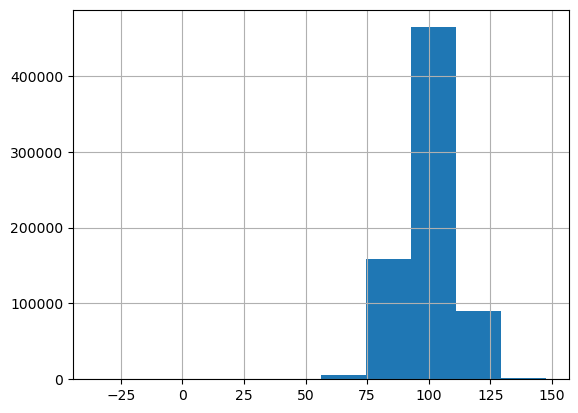

In [31]:
X['stuff+'].hist()

In [32]:
100 + (10 * (0.003394 - y_pred.mean() / y_pred.std()))

np.float64(100.4291580612821)

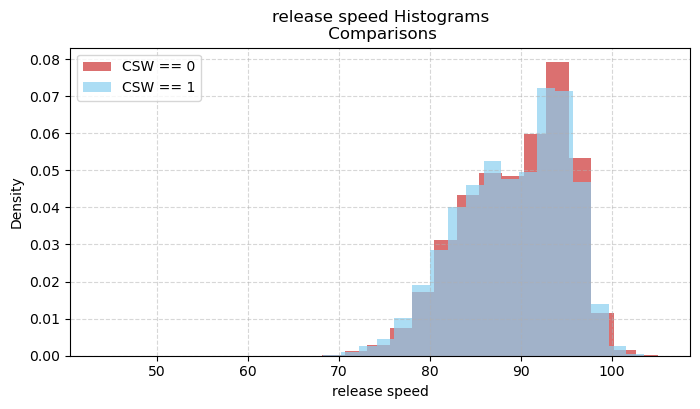

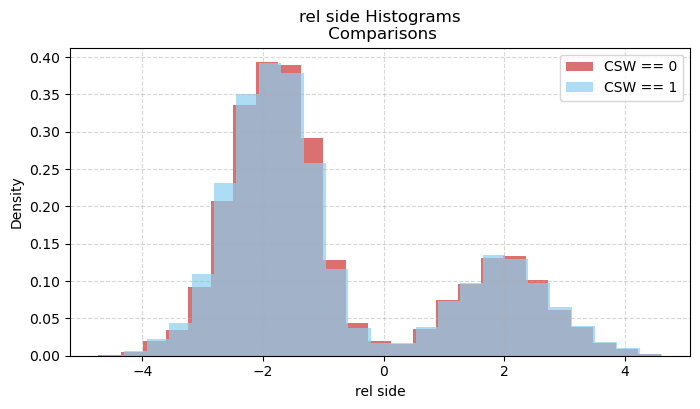

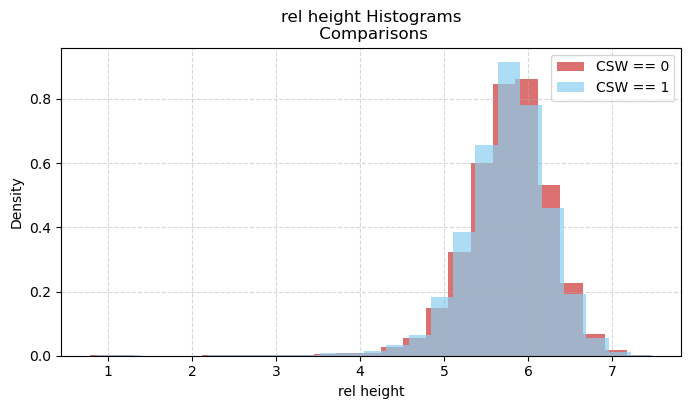

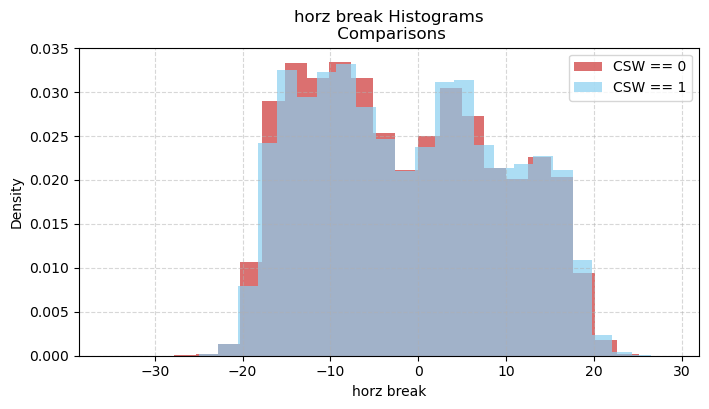

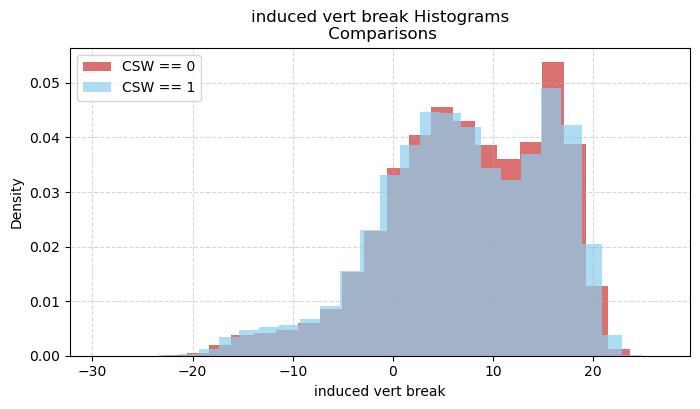

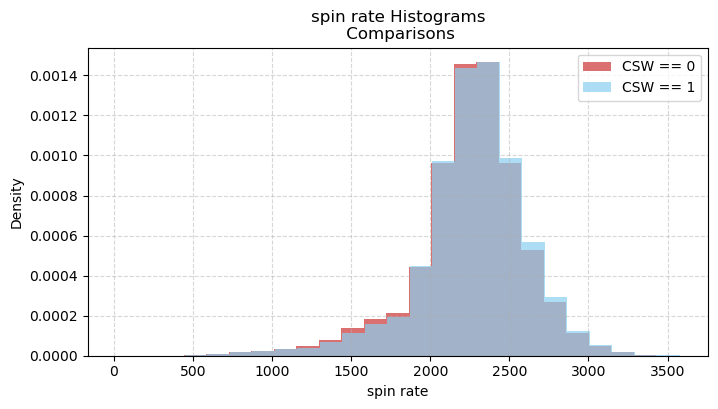

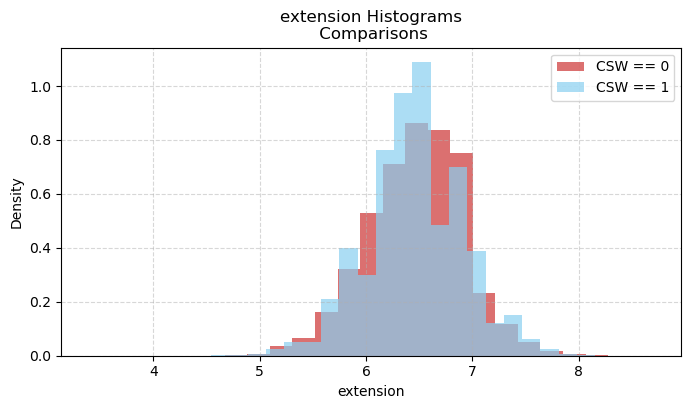

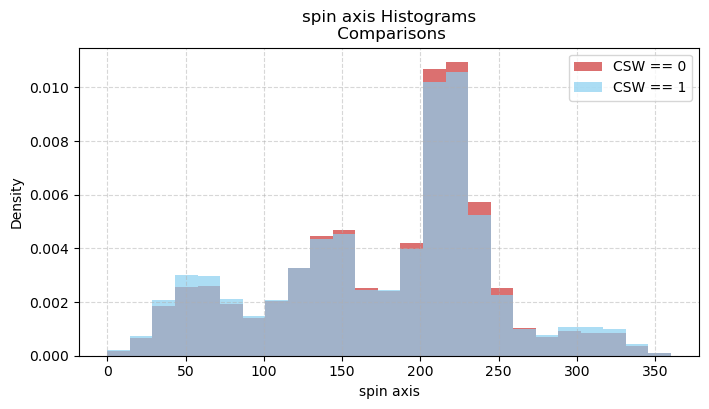

In [33]:
for i in ['release_speed', 'rel_side', 'rel_height', 'horz_break', 'induced_vert_break', 'spin_rate', 'extension', 'spin_axis']:
    catch_made_hist(statcast_data_cleaned, i)

## Result Testing

In [85]:
deep_stats = pitching_stats(2024)
deep_stats.head()

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,GS,CG,ShO,SV,BS,IP,TBF,H,R,ER,HR,BB,IBB,HBP,WP,BK,SO,GB,FB,LD,IFFB,Balls,Strikes,Pitches,RS,IFH,BU,BUH,K/9,BB/9,K/BB,H/9,HR/9,AVG,WHIP,BABIP,LOB%,FIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,Starting,Start-IP,Relieving,Relief-IP,RAR,Dollars,tERA,xFIP,WPA,-WPA,+WPA,RE24,REW,pLI,inLI,gmLI,exLI,Pulls,WPA/LI,Clutch,FB% 2,FBv,SL%,SLv,CT%,CTv,CB%,CBv,CH%,CHv,SF%,SFv,KN%,KNv,XX%,PO%,wFB,wSL,wCT,wCB,wCH,wSF,wKN,wFB/C,wSL/C,wCT/C,wCB/C,wCH/C,wSF/C,wKN/C,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,HLD,SD,MD,ERA-,FIP-,xFIP-,K%,BB%,SIERA,RS/9,E-F,FA% (sc),FT% (sc),FC% (sc),FS% (sc),FO% (sc),SI% (sc),SL% (sc),CU% (sc),KC% (sc),EP% (sc),CH% (sc),SC% (sc),KN% (sc),UN% (sc),vFA (sc),vFT (sc),vFC (sc),vFS (sc),vFO (sc),vSI (sc),vSL (sc),vCU (sc),vKC (sc),vEP (sc),vCH (sc),vSC (sc),vKN (sc),FA-X (sc),FT-X (sc),FC-X (sc),FS-X (sc),FO-X (sc),SI-X (sc),SL-X (sc),CU-X (sc),KC-X (sc),EP-X (sc),CH-X (sc),SC-X (sc),KN-X (sc),FA-Z (sc),FT-Z (sc),FC-Z (sc),FS-Z (sc),FO-Z (sc),SI-Z (sc),SL-Z (sc),CU-Z (sc),KC-Z (sc),EP-Z (sc),CH-Z (sc),SC-Z (sc),KN-Z (sc),wFA (sc),wFT (sc),wFC (sc),wFS (sc),wFO (sc),wSI (sc),wSL (sc),wCU (sc),wKC (sc),wEP (sc),wCH (sc),wSC (sc),wKN (sc),wFA/C (sc),wFT/C (sc),wFC/C (sc),wFS/C (sc),wFO/C (sc),wSI/C (sc),wSL/C (sc),wCU/C (sc),wKC/C (sc),wEP/C (sc),wCH/C (sc),wSC/C (sc),wKN/C (sc),O-Swing% (sc),Z-Swing% (sc),Swing% (sc),O-Contact% (sc),Z-Contact% (sc),Contact% (sc),Zone% (sc),Pace,RA9-WAR,BIP-Wins,LOB-Wins,FDP-Wins,Age Rng,K-BB%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,kwERA,TTO%,CH% (pi),CS% (pi),CU% (pi),FA% (pi),FC% (pi),FS% (pi),KN% (pi),SB% (pi),SI% (pi),SL% (pi),XX% (pi),vCH (pi),vCS (pi),vCU (pi),vFA (pi),vFC (pi),vFS (pi),vKN (pi),vSB (pi),vSI (pi),vSL (pi),vXX (pi),CH-X (pi),CS-X (pi),CU-X (pi),FA-X (pi),FC-X (pi),FS-X (pi),KN-X (pi),SB-X (pi),SI-X (pi),SL-X (pi),XX-X (pi),CH-Z (pi),CS-Z (pi),CU-Z (pi),FA-Z (pi),FC-Z (pi),FS-Z (pi),KN-Z (pi),SB-Z (pi),SI-Z (pi),SL-Z (pi),XX-Z (pi),wCH (pi),wCS (pi),wCU (pi),wFA (pi),wFC (pi),wFS (pi),wKN (pi),wSB (pi),wSI (pi),wSL (pi),wXX (pi),wCH/C (pi),wCS/C (pi),wCU/C (pi),wFA/C (pi),wFC/C (pi),wFS/C (pi),wKN/C (pi),wSB/C (pi),wSI/C (pi),wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi),FRM,K/9+,BB/9+,K/BB+,H/9+,HR/9+,AVG+,WHIP+,BABIP+,LOB%+,K%+,BB%+,LD%+,GB%+,FB%+,HR/FB%+,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xERA,botERA,botOvr CH,botStf CH,botCmd CH,botOvr CU,botStf CU,botCmd CU,botOvr FA,botStf FA,botCmd FA,botOvr SI,botStf SI,botCmd SI,botOvr SL,botStf SL,botCmd SL,botOvr KC,botStf KC,botCmd KC,botOvr FC,botStf FC,botCmd FC,botOvr FS,botStf FS,botCmd FS,botOvr,botStf,botCmd,botxRV100,Stf+ CH,Loc+ CH,Pit+ CH,Stf+ CU,Loc+ CU,Pit+ CU,Stf+ FA,Loc+ FA,Pit+ FA,Stf+ SI,Loc+ SI,Pit+ SI,Stf+ SL,Loc+ SL,Pit+ SL,Stf+ KC,Loc+ KC,Pit+ KC,Stf+ FC,Loc+ FC,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
0,10603,2024,Chris Sale,ATL,35,18,3,6.4,2.38,29,29,0,0,0,0,177.2,702,141,48,47,9,39,0,8,4,1,225,191,143,92,8,925,1893,2818,126,5,4,0,11.40,1.98,5.77,7.14,0.46,0.215,1.01,0.314,0.798,2.09,1.34,0.216,0.448,0.336,0.056,0.063,0.026,0.000,56.2,177.2,NaN,NaN,56.2,$51.3,2.45,2.64,4.04,-9.08,13.12,41.11,4.24,0.95,0.90,0.87,0.83,29,4.37,-0.11,0.455,94.8,0.403,78.7,NaN,NaN,NaN,NaN,0.142,86.9,NaN,NaN,NaN,NaN,0.001,NaN,-5.5,24.4,NaN,NaN,12.1,NaN,NaN,-0.43,2.15,NaN,NaN,3.02,NaN,NaN,0.369,0.646,0.490,0.576,0.812,0.711,0.435,0.694,0.141,0,0,0,57,53,66,0.321,0.056,2.80,6.38,0.30,0.378,NaN,NaN,NaN,NaN,0.072,0.403,NaN,NaN,NaN,0.147,NaN,NaN,NaN,94.8,NaN,NaN,NaN,NaN,94.2,78.6,NaN,NaN,NaN,87.1,NaN,NaN,9.5,NaN,NaN,NaN,NaN,11.1,-5.3,NaN,NaN,NaN,10.1,NaN,NaN,5.8,NaN,NaN,NaN,NaN,1.6,-2.9,NaN,NaN,NaN,0.2,NaN,NaN,-1.3,NaN,NaN,NaN,NaN,-4.0,24.6,NaN,NaN,NaN,12.3,NaN,NaN,-0.12,NaN,NaN,NaN,NaN,-1.99,2.16,NaN,NaN,NaN,2.97,NaN,NaN,0.345,0.623,0.490,0.536,0.802,0.712,0.520,19.6,7.

In [86]:
deep_stats = deep_stats[['Name', 'WAR', 'ERA', 'FIP', 'xFIP', 'K%', 'BB%', 'O-Swing%', 'Z-Swing%', 'O-Contact%', 'Z-Contact%', 'EV', 'HardHit%', 'CSW%', 'Stuff+']].copy()
deep_stats['last_name'] = deep_stats['Name'].str.split().str[1]
deep_stats.head()

,Name,WAR,ERA,FIP,xFIP,K%,BB%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,EV,HardHit%,CSW%,Stuff+,last_name
0,Chris Sale,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,Sale
1,Tarik Skubal,5.9,2.39,2.49,2.83,0.303,0.046,0.352,0.698,0.566,0.801,87.4,0.335,0.321,112,Skubal
2,Zack Wheeler,5.4,2.57,3.13,3.30,0.285,0.066,0.364,0.713,0.641,0.822,86.7,0.332,0.273,110,Wheeler
20,Dylan Cease,4.8,3.47,3.10,3.44,0.294,0.085,0.335,0.706,0.531,0.813,89.0,0.382,0.293,110,Cease
11,Cole Ragans,4.8,3.14,2.99,3.46,0.293,0.088,0.331,0.716,0.577,0.791,88.3,0.352,0.289,110,Ragans


In [87]:
pitch_count = statcast_data_cleaned.groupby('player_name').agg(
    total_pitches = ('pitch_name', 'count')
).reset_index()
pitch_type_count = statcast_data.groupby(['player_name', 'pitch_type']).agg(
    pitch_count = ('pitch_name', 'count')
).reset_index()

pitch_pct = pitch_type_count.merge(pitch_count, on = 'player_name', how = 'left')
pitch_pct['usage%'] = round(pitch_pct['pitch_count'] / pitch_pct['total_pitches'], 3) * 100
pitch_pct['last_name'] = pitch_pct['player_name'].str.split(',').str[0]
pitch_pct.head(8)

,player_name,pitch_type,pitch_count,total_pitches,usage%,last_name
0,"Abbott, Andrew",CH,367,2250.0,16.3,Abbott
1,"Abbott, Andrew",CU,252,2250.0,11.2,Abbott
2,"Abbott, Andrew",FF,1212,2250.0,53.9,Abbott
3,"Abbott, Andrew",SL,5,2250.0,0.2,Abbott
4,"Abbott, Andrew",ST,414,2250.0,18.4,Abbott
5,"Abney, Alaska",CU,3,12.0,25.0,Abney
6,"Abney, Alaska",FF,6,12.0,50.0,Abney
7,"Abney, Alaska",SI,3,12.0,25.0,Abney


In [88]:
deep_stats = pd.merge(deep_stats, pitch_pct, left_on = 'last_name', right_on = 'last_name', how = 'left').copy()
deep_stats = deep_stats.drop(columns = ['Name', 'last_name']).copy()
deep_stats

,WAR,ERA,FIP,xFIP,K%,BB%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,EV,HardHit%,CSW%,Stuff+,player_name,pitch_type,pitch_count,total_pitches,usage%
0,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",CH,400.0,2815.0,14.2
1,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",FF,1075.0,2815.0,38.2
2,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",SI,205.0,2815.0,7.3
3,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",SL,1135.0,2815.0,40.3
4,5.9,2.39,2.49,2.83,0.303,0.046,0.352,0.698,0.566,0.801,87.4,0.335,0.321,112,"Skubal, Tarik",CH,866.0,3062.0,28.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,0.1,5.19,5.26,4.75,0.176,0.089,0.329,0.713,0.621,0.877,90.5,0.417,0.255,86,"Canning, Griffin",CH,774.0,2604.0,29.7
463,0.1,5.19,5.26,4.75,0.176,0.089,0.329,0.713,0.621,0.877,90.5,0.417,0.255,86,"Canning, Griffin",FF,1085.0,2604.0,41.7
464,0.1,5.19,5.26,4.75,0.176,0.089,0.329,0.713,0.621,0.877,90.5,0.417,0.255,86,"Canning, Griffin",KC,315.0,2604.0,12.1
465,0.1,5.19,5.26,4.75,0.176,0.089,0.329,0.713,0.621,0.877,90.5,0.417,0.255,86,"Canning, Griffin",SI,39.0,2604.0,1.5


In [89]:
stuff_df = X[['pitcher', 'pitch_type', 'stuff+']].copy()

In [91]:
both_stuffs = pd.merge(deep_stats, stuff_df, left_on = 'player_name', right_on = 'pitcher', how = 'inner')
both_stuffs = both_stuffs.rename(columns = {'stuff+', 'triStuff+'}).copy()
both_stuffs

TypeError: 'set' object is not callable